In [18]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as func
import torch.utils.data
import torch.nn as nn
from time import time
import os
from matplotlib import pyplot as plt

# Загрузка данных

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dir_name = os.getcwd()
train_img_transform = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10), transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_img_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,0.5))])

train_dataset = datasets.CIFAR10(root=f'{dir_name}/data', train=True, download=True, transform=train_img_transform)
test_dataset = datasets.CIFAR10(root=f'{dir_name}/data', train=False, download=True, transform=test_img_transform)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
def get_accuracy(loader, model):
    tp = 0
    n = 0
    start_time = time()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    end_time = time()
    val_time = end_time - start_time
    accuracy = tp / n
    return accuracy, val_time

def train_model(model, training_loader, loss_function, optimizer, num_epochs):
    if not torch.cuda.is_available():
        raise RuntimeError("Cuda device is not available")
    else: 
        device = torch.device("cuda:0")
        model.to(device)
        print(f'Device: {torch.cuda.get_device_name(device)}')

        total_time = 0
        for epoch in range(num_epochs):
            epoch_start_time = time()
            for i, (images, labels) in enumerate(training_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            accuracy, _ = get_accuracy(training_loader, model)
            epoch_time = time() - epoch_start_time
            total_time += epoch_time
            print(f"Epoch #{epoch+1}: train accuracy = {'{:.3f}'.format(accuracy)}, error = {'{:.3f}'.format(1-accuracy)} time = {'{:.2f}'.format(epoch_time)} sec")
        print(f"Total training time: {total_time} sec")   

In [21]:
import numpy as np
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
def tensor_to_img (tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

def show_images(loader):
    images, labels = next(iter(loader))
    classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 
        3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 
        8: 'ship', 9: 'truck'}
    fig = plt.figure()
    n_x = 3
    n_y = 3
    for img_id in np.arange(9):
        ax = fig.add_subplot(n_x, n_y, img_id + 1, xticks=[], yticks=[])
        ax.set_title(f"Class '{classes[labels[img_id].item()]}'")
        plt.imshow(tensor_to_img(images[img_id]))

Размеры тренировочной и тестовой выборок:

In [22]:
print("Number of train images: ", len(train_dataset))
print("Number of test images: ", len(test_dataset))

Number of train images:  50000
Number of test images:  10000


Примеры данных из тренировочной выборки:

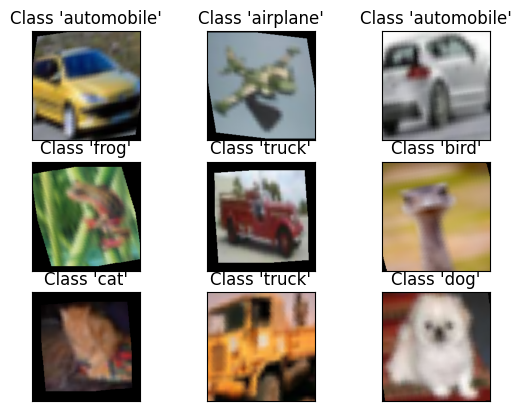

In [23]:
show_images(train_loader)

Примеры данных из тестовой выборки:

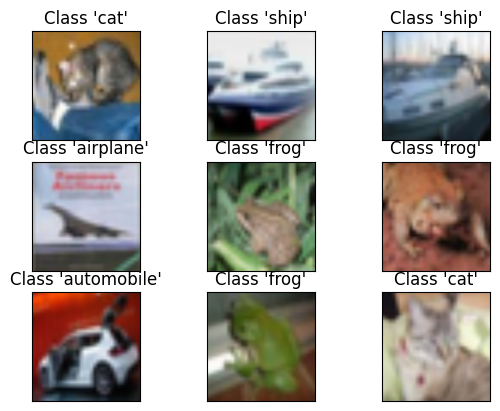

In [24]:
show_images(test_loader)


## Resnet-34

### Эксперимент 1: Resnet34 linear layer, lr 1e-3, epochs 20

* Веса из обученной модели
* Последний линейный слой заменен линейным слоем размерности 10, веса инициализированы методом Xavier
* Полное обучение сети
* 20 эпох
* learning rate = 0.001
* Размер пачки 256

In [25]:
resnet34_lin_layer = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)
resnet34_lin_layer.fc = torch.nn.Linear(resnet34_lin_layer.fc.in_features, 10)
torch.nn.init.xavier_uniform_(resnet34_lin_layer.fc.weight)
resnet34_lin_layer.to(device)
resnet34_lin_layer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
learning_rate = 1e-3
num_epochs = 20
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet34_lin_layer.parameters(), lr=learning_rate)
print(f"Weights init: xavier_uniform_ for fc layer, learning_rate: {learning_rate}, num_epochs: {num_epochs}, batch_size: {batch_size}")

Weights init: xavier_uniform_ for fc layer, learning_rate: 0.001, num_epochs: 20, batch_size: 256


In [27]:
train_model(resnet34_lin_layer, train_loader, loss_function, optimizer, num_epochs)

Device: NVIDIA GeForce RTX 3060
Epoch #1: train accuracy = 0.881, error = 0.119 time = 228.78 sec
Epoch #2: train accuracy = 0.921, error = 0.079 time = 227.16 sec
Epoch #3: train accuracy = 0.926, error = 0.074 time = 226.61 sec
Epoch #4: train accuracy = 0.939, error = 0.061 time = 227.48 sec
Epoch #5: train accuracy = 0.949, error = 0.051 time = 225.53 sec
Epoch #6: train accuracy = 0.951, error = 0.049 time = 224.52 sec
Epoch #7: train accuracy = 0.953, error = 0.047 time = 215.02 sec
Epoch #8: train accuracy = 0.961, error = 0.039 time = 203.69 sec
Epoch #9: train accuracy = 0.963, error = 0.037 time = 203.84 sec
Epoch #10: train accuracy = 0.967, error = 0.033 time = 203.81 sec
Epoch #11: train accuracy = 0.970, error = 0.030 time = 204.08 sec
Epoch #12: train accuracy = 0.969, error = 0.031 time = 204.06 sec
Epoch #13: train accuracy = 0.972, error = 0.028 time = 204.07 sec
Epoch #14: train accuracy = 0.977, error = 0.023 time = 204.07 sec
Epoch #15: train accuracy = 0.978, erro

In [28]:
torch.save(resnet34_lin_layer, "models/resnet34_lin_layer.pt")

In [29]:
resnet34_lin_layer_accuracy, test_time = get_accuracy(test_loader, resnet34_lin_layer)
print(f"Test accuracy: {'{:.3f}'.format(resnet34_lin_layer_accuracy)}, error = {'{:.3f}'.format(1-resnet34_lin_layer_accuracy)}, total test time = {'{:.2f}'.format(test_time)} sec, average_time = {'{:.10f}'.format(test_time/len(test_dataset))}")

Test accuracy: 0.933, error = 0.067, total test time = 10.14 sec, average_time = 0.0010139137


### Эксперимент 2: Resnet34 2 linear layer, lr 1e-3, epochs 20

* Веса из обученной модели
* Последний слой заменен двумя линейными слоями размерности 256 и 10 соответственно, веса инициализированы методом Xavier
* Полное обучение сети
* 20 эпох
* learning rate = 0.001
* Размер пачки 256

In [ ]:
resnet34_fc_layer_train = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)
fc_inputs = resnet34_fc_layer_train.fc.in_features
resnet34_fc_layer_train.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1)
)
torch.nn.init.xavier_uniform_(resnet34_fc_layer_train.fc[0].weight)
torch.nn.init.xavier_uniform_(resnet34_fc_layer_train.fc[3].weight)
resnet34_fc_layer_train.to(device)
resnet34_fc_layer_train

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
learning_rate = 1e-3
num_epochs = 20
loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(resnet34_fc_layer_train.parameters(), lr=learning_rate)
print(f"Weights init: xavier_uniform_ fc, learning_rate: {learning_rate}, num_epochs: {num_epochs}, batch_size: {batch_size}")

Weights init: xavier_uniform_ fc, learning_rate: 0.001, num_epochs: 20, batch_size: 256


In [32]:
train_model(resnet34_fc_layer_train, train_loader, loss_function, optimizer, num_epochs)

Device: NVIDIA GeForce RTX 3060


Epoch #1: train accuracy = 0.862, error = 0.138 time = 203.86 sec
Epoch #2: train accuracy = 0.897, error = 0.103 time = 203.92 sec
Epoch #3: train accuracy = 0.916, error = 0.084 time = 203.95 sec
Epoch #4: train accuracy = 0.922, error = 0.078 time = 204.00 sec
Epoch #5: train accuracy = 0.941, error = 0.059 time = 203.98 sec
Epoch #6: train accuracy = 0.945, error = 0.055 time = 203.99 sec
Epoch #7: train accuracy = 0.946, error = 0.054 time = 203.99 sec
Epoch #8: train accuracy = 0.955, error = 0.045 time = 204.00 sec
Epoch #9: train accuracy = 0.955, error = 0.045 time = 203.98 sec
Epoch #10: train accuracy = 0.960, error = 0.040 time = 204.02 sec
Epoch #11: train accuracy = 0.966, error = 0.034 time = 204.02 sec
Epoch #12: train accuracy = 0.966, error = 0.034 time = 204.03 sec
Epoch #13: train accuracy = 0.965, error = 0.035 time = 204.04 sec
Epoch #14: train accuracy = 0.967, error = 0.033 time = 204.01 sec
Epoch #15: train accuracy = 0.973, error = 0.027 time = 204.00 sec
Epoc

In [33]:
torch.save(resnet34_fc_layer_train, "models/resnet34_fc_layer_train.pt")

In [34]:
resnet34_fc_layer_train_accuracy, test_time = get_accuracy(test_loader, resnet34_fc_layer_train)
print(f"Test accuracy: {'{:.3f}'.format(resnet34_fc_layer_train_accuracy)}, error = {'{:.3f}'.format(1-resnet34_fc_layer_train_accuracy)}, total test time = {'{:.2f}'.format(test_time)} sec, average_time = {'{:.10f}'.format(test_time/len(test_dataset))}")

Test accuracy: 0.935, error = 0.065, total test time = 10.07 sec, average_time = 0.0010065556


## Densenet-121

### Эксперимент 4: densenet121 linear layer, lr 1e-3, epochs 10, SGD optimizer

* Веса из обученной модели
* Последний слой заменен одним линейным слоем, веса инициализированы методом Xavier
* SGD optimizer
* Полное обучение сети
* 10 эпох
* learning rate = 0.001
* Размер пачки 64

In [35]:
densenet121_lin_layer = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
classifier_in_features = densenet121_lin_layer.classifier.in_features
densenet121_lin_layer.classifier = nn.Linear(classifier_in_features, 10)
torch.nn.init.xavier_uniform_(densenet121_lin_layer.classifier.weight)
densenet121_lin_layer.to(device)
densenet121_lin_layer

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [36]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
learning_rate = 1e-3
num_epochs = 10
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(densenet121_lin_layer.parameters(), lr=learning_rate)
print(f"SGD optimizer, weights init: xavier_uniform_ fc, learning_rate: {learning_rate}, num_epochs: {num_epochs}, batch_size: {batch_size}")

SGD optimizer, weights init: xavier_uniform_ fc, learning_rate: 0.001, num_epochs: 10, batch_size: 64


In [37]:
train_model(densenet121_lin_layer, train_loader, loss_function, optimizer, num_epochs)

Device: NVIDIA GeForce RTX 3060


Epoch #1: train accuracy = 0.813, error = 0.187 time = 397.57 sec
Epoch #2: train accuracy = 0.877, error = 0.123 time = 396.55 sec
Epoch #3: train accuracy = 0.900, error = 0.100 time = 396.62 sec
Epoch #4: train accuracy = 0.912, error = 0.088 time = 396.54 sec
Epoch #5: train accuracy = 0.925, error = 0.075 time = 396.65 sec
Epoch #6: train accuracy = 0.931, error = 0.069 time = 396.55 sec
Epoch #7: train accuracy = 0.936, error = 0.064 time = 396.61 sec
Epoch #8: train accuracy = 0.940, error = 0.060 time = 396.57 sec
Epoch #9: train accuracy = 0.944, error = 0.056 time = 396.66 sec
Epoch #10: train accuracy = 0.948, error = 0.052 time = 396.62 sec
Total training time: 3966.940316438675 sec


In [38]:
torch.save(densenet121_lin_layer, "models/densenet121_lin_layer.pt")

In [39]:
densenet121_lin_layer_accuracy, test_time = get_accuracy(test_loader, densenet121_lin_layer)
print(f"Test accuracy: {'{:.3f}'.format(densenet121_lin_layer_accuracy)}, error = {'{:.3f}'.format(1-densenet121_lin_layer_accuracy)}, total test time = {'{:.2f}'.format(test_time)} sec, average_time = {'{:.10f}'.format(test_time/len(test_dataset))}")

Test accuracy: 0.934, error = 0.066, total test time = 20.00 sec, average_time = 0.0019999209


### Эксперимент 5: densenet121 linear layer, lr 1e-3, epochs 10, Adam optimizer

* Веса из обученной модели
* Последний слой заменен одним линейным слоем размерности 10, веса инициализированы методом Xavier
* Adam optimizer
* Полное обучение сети
* 10 эпох
* learning rate = 0.001
* Размер пачки 64

In [40]:
densenet121_lin_layer_adam = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
classifier_in_features = densenet121_lin_layer_adam.classifier.in_features
densenet121_lin_layer_adam.classifier = nn.Linear(classifier_in_features, 10)
torch.nn.init.xavier_uniform_(densenet121_lin_layer_adam.classifier.weight)
densenet121_lin_layer_adam.to(device)
densenet121_lin_layer_adam

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [41]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
learning_rate = 1e-3
num_epochs = 10
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet121_lin_layer_adam.parameters(), lr=learning_rate)
print(f"Adam optimizer, weights init: xavier_uniform_ fc, learning_rate: {learning_rate}, num_epochs: {num_epochs}, batch_size: {batch_size}")

Adam optimizer, weights init: xavier_uniform_ fc, learning_rate: 0.001, num_epochs: 10, batch_size: 64


In [42]:
train_model(densenet121_lin_layer_adam, train_loader, loss_function, optimizer, num_epochs)

Device: NVIDIA GeForce RTX 3060
Epoch #1: train accuracy = 0.867, error = 0.133 time = 397.69 sec
Epoch #2: train accuracy = 0.898, error = 0.102 time = 397.72 sec
Epoch #3: train accuracy = 0.912, error = 0.088 time = 397.77 sec
Epoch #4: train accuracy = 0.928, error = 0.072 time = 397.75 sec
Epoch #5: train accuracy = 0.933, error = 0.067 time = 397.70 sec
Epoch #6: train accuracy = 0.935, error = 0.065 time = 397.77 sec
Epoch #7: train accuracy = 0.943, error = 0.057 time = 397.78 sec
Epoch #8: train accuracy = 0.943, error = 0.057 time = 397.74 sec
Epoch #9: train accuracy = 0.956, error = 0.044 time = 397.78 sec
Epoch #10: train accuracy = 0.959, error = 0.041 time = 397.82 sec
Total training time: 3977.528872728348 sec


In [43]:
torch.save(densenet121_lin_layer_adam, "models/densenet121_lin_layer_adam.pt")

In [44]:
densenet121_lin_layer_adam_accuracy, test_time = get_accuracy(test_loader, densenet121_lin_layer_adam)
print(f"Test accuracy: {'{:.3f}'.format(densenet121_lin_layer_adam_accuracy)}, error = {'{:.3f}'.format(1-densenet121_lin_layer_adam_accuracy)}, total test time = {'{:.2f}'.format(test_time)} sec, average_time = {'{:.10f}'.format(test_time/len(test_dataset))}")

Test accuracy: 0.934, error = 0.066, total test time = 19.97 sec, average_time = 0.0019972086


## Googlenet

### Эксперимент 6: googlenet linear layer, lr 1e-3, epochs 30, all weights init

* Последний слой заменен одним линейным слоем размерности 10
* Все веса инициализированы методом Xavier
* Adam optimizer
* Полное обучение сети
* 30 эпох
* learning rate = 0.001
* Размер пачки 64

In [45]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

googlenet_all_layers_init = torchvision.models.googlenet()
fc_in_features = googlenet_all_layers_init.fc.in_features
googlenet_all_layers_init.fc = nn.Linear(fc_in_features, 10)
googlenet_all_layers_init.apply(init_weights)
googlenet_all_layers_init.to(device)
googlenet_all_layers_init.aux_logits=False
googlenet_all_layers_init


/home/vlad/miniconda3/envs/transf_learn/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [46]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
learning_rate = 1e-3
num_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet_all_layers_init.parameters(), lr=learning_rate)
print(f"Adam optimizer, weights init: xavier_uniform_ fc, learning_rate: {learning_rate}, num_epochs: {num_epochs}, batch_size: {batch_size}")

Adam optimizer, weights init: xavier_uniform_ fc, learning_rate: 0.001, num_epochs: 30, batch_size: 64


In [47]:
train_model(googlenet_all_layers_init, train_loader, loss_function, optimizer, num_epochs)

Device: NVIDIA GeForce RTX 3060


Epoch #1: train accuracy = 0.506, error = 0.494 time = 159.63 sec
Epoch #2: train accuracy = 0.618, error = 0.382 time = 159.86 sec
Epoch #3: train accuracy = 0.710, error = 0.290 time = 160.00 sec
Epoch #4: train accuracy = 0.752, error = 0.248 time = 159.89 sec
Epoch #5: train accuracy = 0.764, error = 0.236 time = 160.02 sec
Epoch #6: train accuracy = 0.792, error = 0.208 time = 160.02 sec
Epoch #7: train accuracy = 0.811, error = 0.189 time = 159.99 sec
Epoch #8: train accuracy = 0.824, error = 0.176 time = 159.36 sec
Epoch #9: train accuracy = 0.846, error = 0.154 time = 159.32 sec
Epoch #10: train accuracy = 0.852, error = 0.148 time = 159.37 sec
Epoch #11: train accuracy = 0.867, error = 0.133 time = 159.91 sec
Epoch #12: train accuracy = 0.872, error = 0.128 time = 160.06 sec
Epoch #13: train accuracy = 0.883, error = 0.117 time = 159.76 sec
Epoch #14: train accuracy = 0.881, error = 0.119 time = 159.93 sec
Epoch #15: train accuracy = 0.901, error = 0.099 time = 159.33 sec
Epoc

In [48]:
torch.save(googlenet_all_layers_init, "models/googlenet_all_layers_init.pt")

In [49]:
googlenet_all_layers_init_accuracy, test_time = get_accuracy(test_loader, googlenet_all_layers_init)
print(f"Test accuracy: {'{:.3f}'.format(googlenet_all_layers_init_accuracy)}, error = {'{:.3f}'.format(1-googlenet_all_layers_init_accuracy)}, total test time = {'{:.2f}'.format(test_time)} sec, average_time = {'{:.10f}'.format(test_time/len(test_dataset))}")

Test accuracy: 0.875, error = 0.125, total test time = 7.72 sec, average_time = 0.0007717209


### Эксперимент 7: googlenet linear layer, lr 1e-3, epochs 30, last layer weights init

* Веса из обученной модели
* Последний слой заменен одним линейным слоем размерности 10
* Веса последнего слоя инициализированы методом Xavier
* Adam optimizer
* Полное обучение сети
* 30 эпох
* learning rate = 0.001
* Размер пачки 64

In [50]:
googlenet_last_layers_init = torchvision.models.googlenet(weights=torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1)
fc_in_features = googlenet_last_layers_init.fc.in_features
googlenet_last_layers_init.fc = nn.Linear(fc_in_features, 10)
torch.nn.init.xavier_uniform_(googlenet_last_layers_init.fc.weight)
googlenet_last_layers_init.to(device)
googlenet_last_layers_init.aux_logits=False
googlenet_last_layers_init

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [51]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
learning_rate = 1e-3
num_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet_last_layers_init.parameters(), lr=learning_rate)
print(f"Adam optimizer, weights init: xavier_uniform_ fc, learning_rate: {learning_rate}, num_epochs: {num_epochs}, batch_size: {batch_size}")

Adam optimizer, weights init: xavier_uniform_ fc, learning_rate: 0.001, num_epochs: 30, batch_size: 64


In [52]:
train_model(googlenet_last_layers_init, train_loader, loss_function, optimizer, num_epochs)

Device: NVIDIA GeForce RTX 3060


Epoch #1: train accuracy = 0.870, error = 0.130 time = 158.59 sec
Epoch #2: train accuracy = 0.895, error = 0.105 time = 159.28 sec
Epoch #3: train accuracy = 0.913, error = 0.087 time = 159.41 sec
Epoch #4: train accuracy = 0.923, error = 0.077 time = 159.15 sec
Epoch #5: train accuracy = 0.922, error = 0.078 time = 159.26 sec
Epoch #6: train accuracy = 0.935, error = 0.065 time = 159.35 sec
Epoch #7: train accuracy = 0.939, error = 0.061 time = 159.46 sec
Epoch #8: train accuracy = 0.948, error = 0.052 time = 159.33 sec
Epoch #9: train accuracy = 0.949, error = 0.051 time = 159.51 sec
Epoch #10: train accuracy = 0.947, error = 0.053 time = 159.29 sec
Epoch #11: train accuracy = 0.951, error = 0.049 time = 159.31 sec
Epoch #12: train accuracy = 0.959, error = 0.041 time = 159.46 sec
Epoch #13: train accuracy = 0.963, error = 0.037 time = 159.38 sec
Epoch #14: train accuracy = 0.964, error = 0.036 time = 159.51 sec
Epoch #15: train accuracy = 0.967, error = 0.033 time = 159.35 sec
Epoc

In [53]:
torch.save(googlenet_last_layers_init, "models/googlenet_last_layers_init.pt")

In [54]:
googlenet_last_layers_init_accuracy, test_time = get_accuracy(test_loader, googlenet_last_layers_init)
print(f"Test accuracy: {'{:.3f}'.format(googlenet_last_layers_init_accuracy)}, error = {'{:.3f}'.format(1-googlenet_last_layers_init_accuracy)}, total test time = {'{:.2f}'.format(test_time)} sec, average_time = {'{:.10f}'.format(test_time/len(test_dataset))}")

Test accuracy: 0.935, error = 0.065, total test time = 7.69 sec, average_time = 0.0007687001


## Efficientnet-v2-s

### Эксперимент 8: efficientnet_v2_s linear layer, lr 1e-5, epochs 30, last layer weights init

* Веса из обученной модели
* Последний слой заменен одним линейным слоем размерности 10
* Веса последнего слоя инициализированы методом Xavier
* Adam optimizer
* Полное обучение сети
* 30 эпох
* learning rate = 0.00001
* Размер пачки 64

In [55]:
efficientnet_v2_s = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
classifier_in_features = efficientnet_v2_s.classifier[1].in_features
efficientnet_v2_s.classifier[1] = nn.Linear(classifier_in_features, 10)
torch.nn.init.xavier_uniform_(efficientnet_v2_s.classifier[1].weight)
efficientnet_v2_s.to(device)
efficientnet_v2_s

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [56]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
learning_rate = 1e-5
num_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_v2_s.parameters(), lr=learning_rate)
print(f"Adam optimizer, weights init: xavier_uniform_ fc, learning_rate: {learning_rate}, num_epochs: {num_epochs}, batch_size: {batch_size}")

Adam optimizer, weights init: xavier_uniform_ fc, learning_rate: 1e-05, num_epochs: 30, batch_size: 64


In [57]:
train_model(efficientnet_v2_s, train_loader, loss_function, optimizer, num_epochs)

Device: NVIDIA GeForce RTX 3060


Epoch #1: train accuracy = 0.888, error = 0.112 time = 404.08 sec
Epoch #2: train accuracy = 0.931, error = 0.069 time = 404.05 sec
Epoch #3: train accuracy = 0.949, error = 0.051 time = 404.05 sec
Epoch #4: train accuracy = 0.959, error = 0.041 time = 404.03 sec
Epoch #5: train accuracy = 0.968, error = 0.032 time = 404.04 sec
Epoch #6: train accuracy = 0.974, error = 0.026 time = 404.08 sec
Epoch #7: train accuracy = 0.978, error = 0.022 time = 404.07 sec
Epoch #8: train accuracy = 0.982, error = 0.018 time = 404.09 sec
Epoch #9: train accuracy = 0.985, error = 0.015 time = 404.10 sec
Epoch #10: train accuracy = 0.987, error = 0.013 time = 404.09 sec
Epoch #11: train accuracy = 0.988, error = 0.012 time = 404.11 sec
Epoch #12: train accuracy = 0.991, error = 0.009 time = 404.11 sec
Epoch #13: train accuracy = 0.991, error = 0.009 time = 404.08 sec
Epoch #14: train accuracy = 0.993, error = 0.007 time = 404.10 sec
Epoch #15: train accuracy = 0.994, error = 0.006 time = 404.07 sec
Epoc

In [58]:
torch.save(efficientnet_v2_s, "models/efficientnet_v2_s.pt")

In [59]:
efficientnet_v2_s_accuracy, test_time = get_accuracy(test_loader, efficientnet_v2_s)
print(f"Test accuracy: {'{:.3f}'.format(efficientnet_v2_s_accuracy)}, error = {'{:.3f}'.format(1-efficientnet_v2_s_accuracy)}, total test time = {'{:.2f}'.format(test_time)} sec, average_time = {'{:.10f}'.format(test_time/len(test_dataset))}")

Test accuracy: 0.972, error = 0.028, total test time = 18.75 sec, average_time = 0.0018748394


### Эксперимент 9: efficientnet_v2_s linear layer, lr 1e-3, epochs 30, last layer weights init

* Веса из обученной модели
* Последний слой заменен одним линейным слоем размерности 10
* Веса последнего слоя инициализированы методом Xavier
* Adam optimizer
* Полное обучение сети
* 30 эпох
* learning rate = 0.001
* Размер пачки 64

In [60]:
efficientnet_v2_s_another_lr = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
classifier_in_features = efficientnet_v2_s_another_lr.classifier[1].in_features
efficientnet_v2_s_another_lr.classifier[1] = nn.Linear(classifier_in_features, 10)
torch.nn.init.xavier_uniform_(efficientnet_v2_s_another_lr.classifier[1].weight)
efficientnet_v2_s_another_lr.to(device)
efficientnet_v2_s_another_lr

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [61]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
learning_rate = 1e-3
num_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_v2_s_another_lr.parameters(), lr=learning_rate)
print(f"Adam optimizer, weights init: xavier_uniform_ fc, learning_rate: {learning_rate}, num_epochs: {num_epochs}, batch_size: {batch_size}")

Adam optimizer, weights init: xavier_uniform_ fc, learning_rate: 0.001, num_epochs: 30, batch_size: 64


In [62]:
train_model(efficientnet_v2_s_another_lr, train_loader, loss_function, optimizer, num_epochs)

Device: NVIDIA GeForce RTX 3060
Epoch #1: train accuracy = 0.884, error = 0.116 time = 404.71 sec
Epoch #2: train accuracy = 0.921, error = 0.079 time = 404.66 sec
Epoch #3: train accuracy = 0.941, error = 0.059 time = 404.70 sec
Epoch #4: train accuracy = 0.942, error = 0.058 time = 404.75 sec
Epoch #5: train accuracy = 0.945, error = 0.055 time = 404.70 sec
Epoch #6: train accuracy = 0.952, error = 0.048 time = 404.67 sec
Epoch #7: train accuracy = 0.958, error = 0.042 time = 404.70 sec
Epoch #8: train accuracy = 0.962, error = 0.038 time = 404.65 sec
Epoch #9: train accuracy = 0.960, error = 0.040 time = 404.65 sec
Epoch #10: train accuracy = 0.966, error = 0.034 time = 404.64 sec
Epoch #11: train accuracy = 0.966, error = 0.034 time = 404.65 sec
Epoch #12: train accuracy = 0.966, error = 0.034 time = 404.63 sec
Epoch #13: train accuracy = 0.971, error = 0.029 time = 404.67 sec
Epoch #14: train accuracy = 0.972, error = 0.028 time = 404.70 sec
Epoch #15: train accuracy = 0.979, erro

In [63]:
torch.save(efficientnet_v2_s_another_lr, "models/efficientnet_v2_s_another_lr.pt")

In [64]:
efficientnet_v2_s_another_lr_accuracy, test_time = get_accuracy(test_loader, efficientnet_v2_s_another_lr)
print(f"Test accuracy: {'{:.3f}'.format(efficientnet_v2_s_another_lr_accuracy)}, error = {'{:.3f}'.format(1-efficientnet_v2_s_another_lr_accuracy)}, total test time = {'{:.2f}'.format(test_time)} sec, average_time = {'{:.10f}'.format(test_time/len(test_dataset))}")

Test accuracy: 0.940, error = 0.060, total test time = 18.71 sec, average_time = 0.0018709673


# Результаты

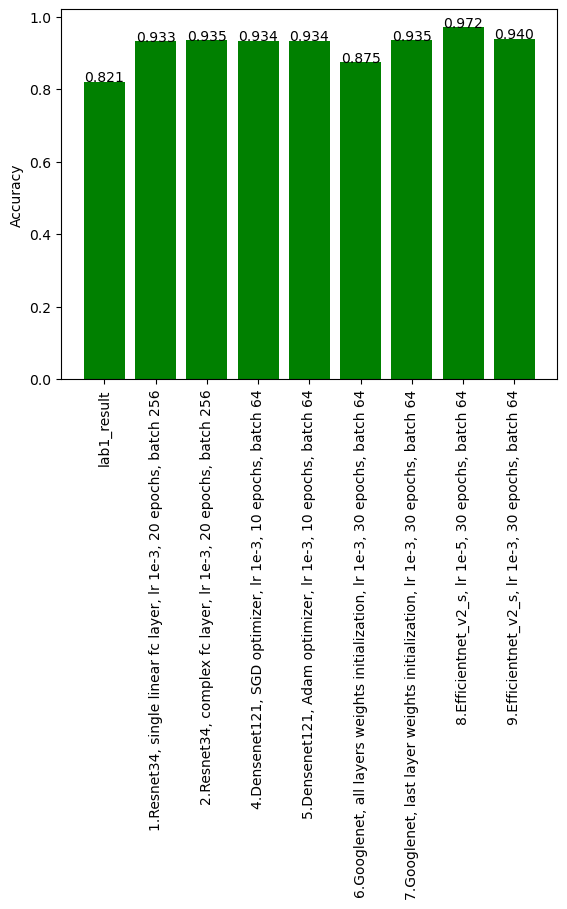

In [1]:
import matplotlib.pyplot as plt

# function to add value labels
def addlabels(x,y):
    for i, val in enumerate(y):
        plt.text(i, val, '{:.3f}'.format(val), ha = 'center')

accuracy_dict = {
    "lab1_result": 0.821,
    "1.Resnet34, single linear fc layer, lr 1e-3, 20 epochs, batch 256": 0.933,
    "2.Resnet34, complex fc layer, lr 1e-3, 20 epochs, batch 256": 0.935,
    "4.Densenet121, SGD optimizer, lr 1e-3, 10 epochs, batch 64": 0.934,
    "5.Densenet121, Adam optimizer, lr 1e-3, 10 epochs, batch 64": 0.934,
    "6.Googlenet, all layers weights initialization, lr 1e-3, 30 epochs, batch 64": 0.875,
    "7.Googlenet, last layer weights initialization, lr 1e-3, 30 epochs, batch 64": 0.935,
    "8.Efficientnet_v2_s, lr 1e-5, 30 epochs, batch 64": 0.972,
    "9.Efficientnet_v2_s, lr 1e-3, 30 epochs, batch 64": 0.940,
}
plt.bar(list(accuracy_dict.keys()), accuracy_dict.values(), color='g')
addlabels(list(accuracy_dict.keys()), accuracy_dict.values())
plt.xticks(rotation = 90)
plt.ylabel("Accuracy")
plt.show()

## Вывод
* Лучшая модель: EfficientNet_V2_S.

* Модифицированные слои: последний слой заменен линейным слоем размерности 10.

* Тип эксперимента: полное обучение сети, веса из обученной сети, веса последнего слоя инициализированы методом Xavier.

* Параметры обучения: алгоритм оптимизации Adam, learning_rate = 0.00001, количество эпох 30, размер пачки 64, веса последнего слоя проинициализированы методом Xavier.

* Точность классификации на тестовой выборке 0.972